In [76]:
#importing the libraries
import pandas as pd
import seaborn as sns
import numpy as np
import warnings
import os
import seaborn as sns
import matplotlib.pyplot as plt

## What is Permutation Entropy?

Permutation Entropy (PE) is a robust time series tool which provides a quantification measure of the complexity of a dynamic system by capturing the order relations between values of a time series and extracting a probability distribution of the ordinal patterns


Entropy=Xp(π) log p(π)

In [ ]:
#mount from the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## this is the Path where all the Activity-wise folders are located
folder_path = r'/content/drive/MyDrive/data'

In [ ]:
# Changing  the current working directory as the above folder path
os.chdir(folder_path)

In [ ]:
#display the content of the directory
folders=os.listdir()

folders

['acc_climbingdown', 'acc_walking', 'acc_running', 'acc_climbingup']

In [ ]:
#defining the shannon entropy of the time series
def shannon_entropy(frequency_list):
    """Calculate the shannon entropy of a time series.
    Parameters
    ----------
    x : 1d-array
        Time series of shape (n_times)
    emb_dim : int
        Embedding dimension
    delay : int
        Delay between elements of a pattern
    Returns
    -------
    se : float
        Shannon entropy
    Notes
    -----
    The shannon entropy is a complexity measure for time series first
    introduced by Bandt and Pompe in 2002 [1]_.
    It is based on two ideas: (1) patterns in a time series contain more
    information than single data points (2) less complex systems exhibit
    more regular patterns. The shannon entropy of a time series quantifies
    how many distinct patterns of length ``emb_dim`` it contains. A lower
    shannon entropy means that the time series is more regular and thus
    less complex.
    The shannon entropy of a time series ``x`` with embedding dimension
    ``emb_dim`` and time delay ``delay`` is defined as:
    .. math::
        H = - \sum p(i) \log_2 p(i)
    where :math:`p(i)` is the relative frequency of the :math:`i`-th most
    common pattern.
    """

    frequency_list = [element for element in frequency_list if element != 0]
    shan_entropy = 0.0
    for freq in frequency_list:
        shan_entropy += freq * np.log(freq)
    shan_entropy = -shan_entropy
    return(shan_entropy)

In [ ]:
#defining the ordinal patterns of the time series
def ordinal_patterns(ts, embed_dim, embed_delay):
  """Calculate the ordinal patterns of a time series.
    Parameters
    ----------
    ts : 1d-array
        Time series of shape (n_times)
    embed_dim : int
        Embedding dimension
    embed_delay : int
        Delay between elements of a pattern
    Returns
    -------
    patterns : 1d-array
        Ordinal patterns
    Notes
    -----
    The ordinal patterns are a complexity measure for time series first
    introduced by Bandt and Pompe in 2002 [1]_.
    It is based on two ideas: (1) patterns in a time series contain more
    information than single data points (2) less complex systems exhibit
    more regular patterns. The ordinal patterns of a time series quantifies
    how many distinct patterns of length ``emb_dim`` it contains. A lower
    ordinal patterns means that the time series is more regular and thus
    less complex.
    The ordinal patterns of a time series ``x`` with embedding dimension
    ``emb_dim`` and time delay ``delay`` is defined as:
    .. math::
        H = - \sum p(i) \log_2 p(i)
    where :math:`p(i)` is the relative frequency of the :math:`i`-th most
    common pattern.
    """

  k, l = embed_dim, embed_delay
  x = ts if isinstance(ts, np.ndarray) else np.array(ts) 

  tmp = np.zeros((x.shape[0], k))
  for i in range(k):
      tmp[:, i] = np.roll(x, i*l)
  partition = tmp[(l*k-1):, :] 
  permutation = np.argsort(partition)
  idx = _hash(permutation)

  counts = np.zeros(np.math.factorial(k))
  for i in range(counts.shape[0]):
    counts[i] = (idx == i).sum()
  return list(counts[counts != 0].astype(int))

In [ ]:
#defining the hash value of the time series
def _hash(x):
  """
  Calculate the hash value of a time series.
    Parameters
    ----------
    x : 1d-array
        Time series of shape (n_times)
    Returns
    -------
    hash_value : int
        Hash value
    Notes
    -----
    The hash value is a complexity measure for time series first introduced
    by Bandt and Pompe in 2002 [1]_.
    It is based on two ideas: (1) patterns in a time series contain more
    information than single data points (2) less complex systems exhibit
    more regular patterns. The hash value of a time series quantifies
    how many distinct patterns of length ``emb_dim`` it contains. A lower
    hash value means that the time series is more regular and thus
    less complex.
    """
  m, n = x.shape
  if n == 1:
    return np.zeros(m)
  return np.sum(np.apply_along_axis(lambda y: y < x[:, 0], 0, x), axis=1) * np.math.factorial(n-1) + _hash(x[:, 1:]) 

In [ ]:
#defining the permutation entropy of the time series
def permutation_entropy(ordinal_pattern):
  """
  Calculate the permutation entropy of a time series.
    Parameters
    ----------
    x : 1d-array
        Time series of shape (n_times)
    emb_dim : int
        Embedding dimension
    delay : int
        Delay between elements of a pattern
    normalize : bool
        Normalize the permutation entropy by the natural logarithm of the
        number of patterns
    Returns
    -------
    pe : float
        Permutation entropy
    Notes
    -----
    The permutation entropy is a complexity measure for time series first
    introduced by Bandt and Pompe in 2002 [1]_.
    It is based on two ideas: (1) patterns in a time series contain more
    information than single data points (2) less complex systems exhibit
    more regular patterns. The permutation entropy of a time series
    quantifies how many distinct patterns of length ``emb_dim`` it
    contains. A lower permutation entropy means that the time series is
    more regular and thus less complex.
    The permutation entropy of a time series ``x`` with embedding dimension
    ``emb_dim`` and time delay ``delay`` is defined as:
    .. math::
        H = - \sum p(i) \log_2 p(i)
    where :math:`p(i)` is the relative frequency of the :math:`i`-th most
    common pattern.
  """
  ordinal_patt = ordinal_pattern
  max_entropy = np.log(len(ordinal_patt))
  p = np.divide(np.array(ordinal_patt), float(sum(ordinal_patt)))
  return(shannon_entropy(p)/max_entropy)

In [ ]:
#defining the permutation complexity of the time series
def complexity(op):
    """ 
    This function computes the complexity of a time series defined as: Comp_JS = Q_o * JSdivergence * pe
    Q_o = Normalizing constant
    JSdivergence = Jensen-Shannon divergence
    pe = permutation entopry
    ARGS: ordinal pattern
    """
    pe = permutation_entropy(op)
    constant1 = (0.5+((1 - 0.5)/len(op)))* np.log(0.5+((1 - 0.5)/len(op)))
    constant2 = ((1 - 0.5)/len(op))*np.log((1 - 0.5)/len(op))*(len(op) - 1)
    constant3 = 0.5*np.log(len(op))
    Q_o = -1/(constant1+constant2+constant3)

    temp_op_prob = np.divide(op, sum(op))
    temp_op_prob2 = (0.5*temp_op_prob)+(0.5*(1/len(op)))
    JSdivergence = (shannon_entropy(temp_op_prob2) - 0.5 * shannon_entropy(temp_op_prob) - 0.5 * np.log(len(op)))
    Comp_JS = Q_o * JSdivergence * pe
    return(Comp_JS)


In [ ]:
#defining the weighted ordinal patterns of the time series
def weighted_ordinal_patterns(ts, embdim, embdelay):
  """
  Calculate the weighted ordinal patterns of a time series.
    Parameters
    ----------
    x : 1d-array
        Time series of shape (n_times)
    emb_dim : int
        Embedding dimension
    delay : int
        Delay between elements of a pattern
    Returns
        1d-array weighted ordinal patterns
    -------

  """
  m, t = embdim, embdelay
  x = ts if isinstance(ts, np.ndarray) else np.array(ts) 

  tmp = np.zeros((x.shape[0], m))
  for i in range(m):
      tmp[:, i] = np.roll(x, i*t)
  partition = tmp[(t*m-1):, :] 
  xm = np.mean(partition, axis=1)
  weight = np.mean((partition - xm[:, None])**2, axis=1)
  permutation = np.argsort(partition)
  idx = _hash(permutation)
  counts = np.zeros(np.math.factorial(m))
  for i in range(counts.shape[0]):
      counts[i] = sum(weight[i == idx])

  return list(counts[counts != 0]) 

In [ ]:
#loading the dataset with column names
data_2 = pd.DataFrame(columns = ['Subject', 'Accelerometer Axis', 'Signal Length', 'Dimension', 'Delay', 
                                    'Permutation Entropy', 'Complexity', 'Activity','Position'])

In [ ]:
#defining the values for each column using for loop

for folder in folders:
    files=[]
    files.extend(os.listdir(folder))
    for file in files:
        df = pd.read_csv(folder_path+'//'+folder+'//'+file)
        for ax in ['attr_x','attr_y','attr_z']:
            for i in np.array([3,4,5,6]): ##embedded dimension 
                for j in np.array([1,2,3]): ##embedded delay 
                    for k in np.array([1024, 2048, 4096]): ##signal length
                        
                        file_len = len(file.split('_'))
                        if file_len == 4:
                            """
                            Split the text whereever there is underscore
                            """
                            Activity = file.split('_')[1]
                            Position = file.split('_')[2]
                            sub = file.split('_')[-1].split('.')[0]
                            
                        elif file_len > 4:
                            Activity = file.split('_')[1]
                            Position = file.split('_')[2]
                            sub = file.split('_')[-2].split('.')[0] 
                            
                        data_2 = data_2.append({'Subject': sub, 'Accelerometer Axis': ax , 'Signal Length': k,
                                     'Dimension' : i, 'Delay':j, 
                                     'Permutation Entropy': permutation_entropy(ordinal_patterns(df[ax][1000:1000+k], i, j)), 
                                     'Complexity': complexity(ordinal_patterns(df[ax][1000:1000+k], i, j)), 
                                      'Activity': Activity, 'Position' : Position}, ignore_index = True)
                        print(data_2.shape)
kp2

Streaming output truncated to the last 5000 lines.
(7961, 9)
(7962, 9)
(7963, 9)
(7964, 9)
(7965, 9)
(7966, 9)
(7967, 9)
(7968, 9)
(7969, 9)
(7970, 9)
(7971, 9)
(7972, 9)
(7973, 9)
(7974, 9)
(7975, 9)
(7976, 9)
(7977, 9)
(7978, 9)
(7979, 9)
(7980, 9)
(7981, 9)
(7982, 9)
(7983, 9)
(7984, 9)
(7985, 9)
(7986, 9)
(7987, 9)
(7988, 9)
(7989, 9)
(7990, 9)
(7991, 9)
(7992, 9)
(7993, 9)
(7994, 9)
(7995, 9)
(7996, 9)
(7997, 9)
(7998, 9)
(7999, 9)
(8000, 9)
(8001, 9)
(8002, 9)
(8003, 9)
(8004, 9)
(8005, 9)
(8006, 9)
(8007, 9)
(8008, 9)
(8009, 9)
(8010, 9)
(8011, 9)
(8012, 9)
(8013, 9)
(8014, 9)
(8015, 9)
(8016, 9)
(8017, 9)
(8018, 9)
(8019, 9)
(8020, 9)
(8021, 9)
(8022, 9)
(8023, 9)
(8024, 9)
(8025, 9)
(8026, 9)
(8027, 9)
(8028, 9)
(8029, 9)
(8030, 9)
(8031, 9)
(8032, 9)
(8033, 9)
(8034, 9)
(8035, 9)
(8036, 9)
(8037, 9)
(8038, 9)
(8039, 9)
(8040, 9)
(8041, 9)
(8042, 9)
(8043, 9)
(8044, 9)
(8045, 9)
(8046, 9)
(8047, 9)
(8048, 9)
(8049, 9)
(8050, 9)
(8051, 9)
(8052, 9)
(8053, 9)
(8054, 9)
(8055, 9)

,Subject,Accelerometer Axis,Signal Length,Dimension,Delay,Permutation Entropy,Complexity,Activity,Position
0,4,attr_x,1024,3,1,0.867223,0.111551,climbingdown,chest
1,4,attr_x,2048,3,1,0.870853,0.108867,climbingdown,chest
2,4,attr_x,4096,3,1,0.874232,0.106320,climbingdown,chest
3,4,attr_x,1024,3,2,0.980732,0.018249,climbingdown,chest
4,4,attr_x,2048,3,2,0.981871,0.017200,climbingdown,chest
...,...,...,...,...,...,...,...,...,...
12955,2,attr_z,2048,6,2,0.878017,0.193788,climbingup,chest
12956,2,attr_z,4096,6,2,0.855875,0.223548,climbingup,chest
12957,2,attr_z,1024,6,3,0.934533,0.119783,climbingup,chest
12958,2,attr_z,2048,6,3,0.891608,0.181132,climbingup,chest


In [ ]:
#printing the results
data_2

,Subject,Accelerometer Axis,Signal Length,Dimension,Delay,Permutation Entropy,Complexity,Activity,Position
0,4,attr_x,1024,3,1,0.867223,0.111551,climbingdown,chest
1,4,attr_x,2048,3,1,0.870853,0.108867,climbingdown,chest
2,4,attr_x,4096,3,1,0.874232,0.106320,climbingdown,chest
3,4,attr_x,1024,3,2,0.980732,0.018249,climbingdown,chest
4,4,attr_x,2048,3,2,0.981871,0.017200,climbingdown,chest
...,...,...,...,...,...,...,...,...,...
12955,2,attr_z,2048,6,2,0.878017,0.193788,climbingup,chest
12956,2,attr_z,4096,6,2,0.855875,0.223548,climbingup,chest
12957,2,attr_z,1024,6,3,0.934533,0.119783,climbingup,chest
12958,2,attr_z,2048,6,3,0.891608,0.181132,climbingup,chest


In [ ]:
#importing sys (System) module which provides functions and variables which are used to manipulate different parts of the Python Runtime Environment.
import sys
np.set_printoptions(threshold=sys.maxsize)

In [ ]:
from tabulate import tabulate
print(tabulate(data_2, headers = data_2.columns, tablefmt = 'pretty', showindex=False))

+---------+--------------------+---------------+-----------+-------+---------------------+------------------------+--------------+----------+
| Subject | Accelerometer Axis | Signal Length | Dimension | Delay | Permutation Entropy |       Complexity       |   Activity   | Position |
+---------+--------------------+---------------+-----------+-------+---------------------+------------------------+--------------+----------+
|    4    |       attr_x       |     1024      |     3     |   1   | 0.8672233024586044  |  0.11155080568125428   | climbingdown |  chest   |
|    4    |       attr_x       |     2048      |     3     |   1   | 0.8708525656803842  |  0.10886705737151964   | climbingdown |  chest   |
|    4    |       attr_x       |     4096      |     3     |   1   | 0.8742323907760187  |  0.10632010624310585   | climbingdown |  chest   |
|    4    |       attr_x       |     1024      |     3     |   2   | 0.9807317779597498  |  0.01824903386788645   | climbingdown |  chest   |
|    4

## Scatter Plots

In [ ]:
#computing the running and walking part from the Activity column
run_walk = data_2[(data_2['Activity']=='running') | (data_2['Activity']=='walking')]

In [ ]:
run_walk.columns

Index(['Subject', 'Accelerometer Axis', 'Signal Length', 'Dimension', 'Delay',
       'Permutation Entropy', 'Complexity', 'Activity', 'Position'],
      dtype='object')

In [ ]:
#equating to signal length=4096 and delay=1
run_walk_1 = run_walk[(run_walk['Signal Length']==4096) & (run_walk['Delay']==1)]

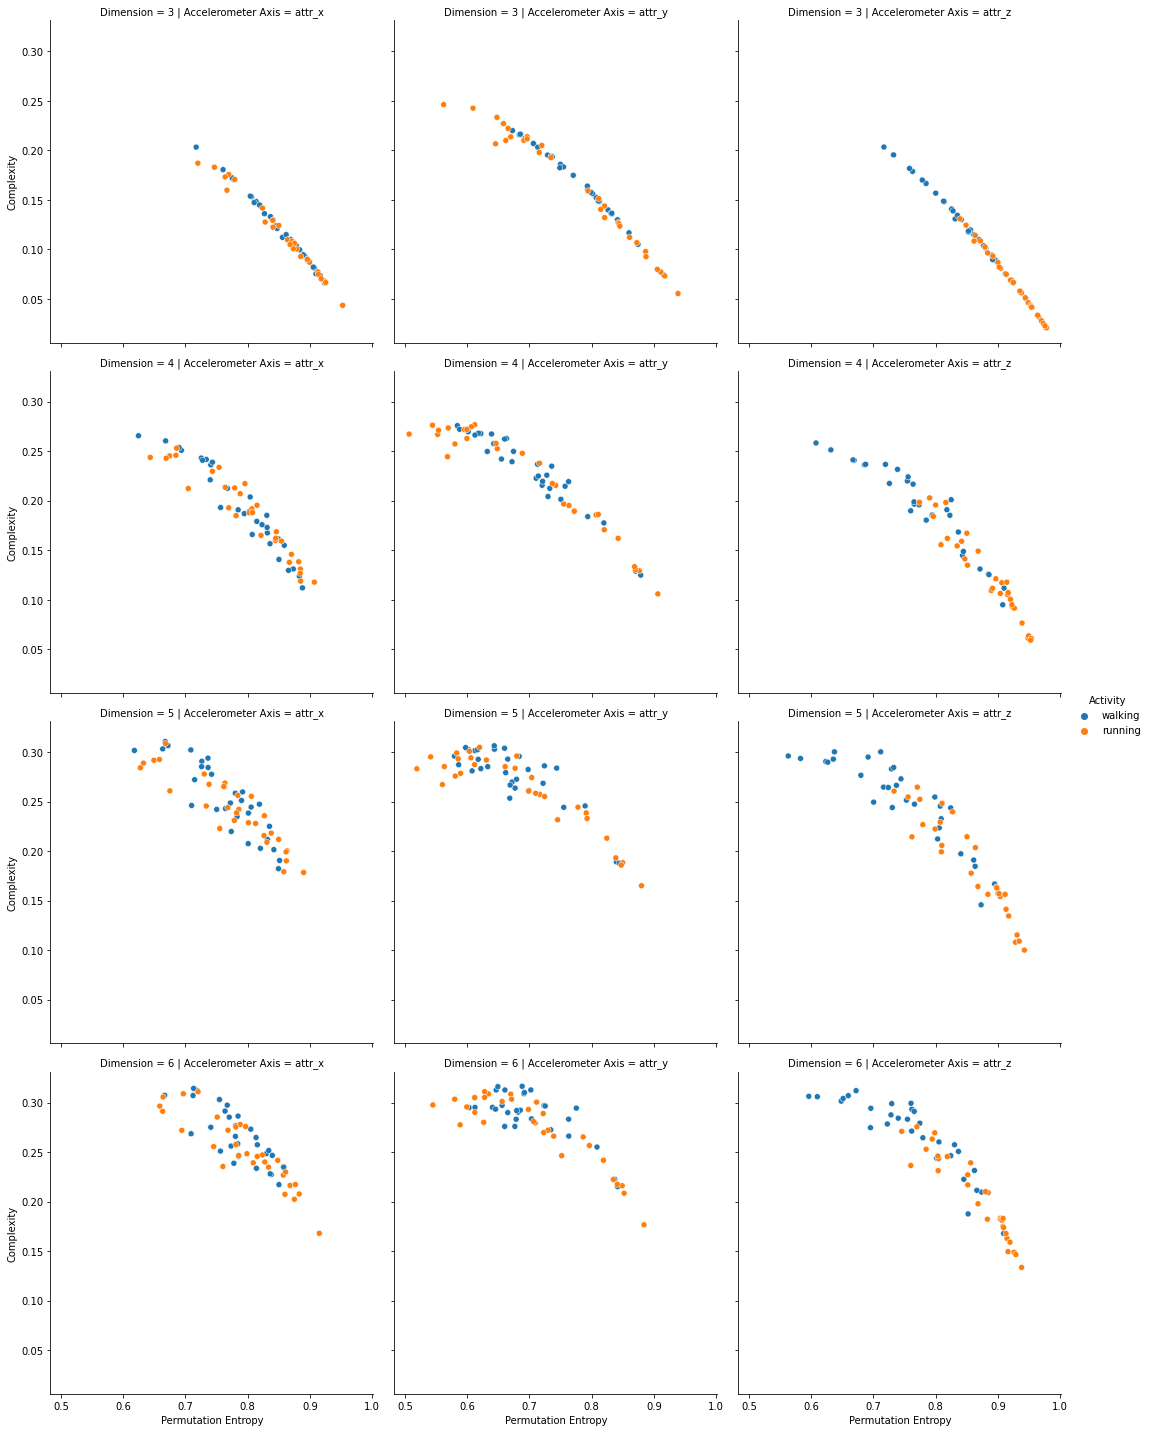

In [ ]:
#displaying the relational plot between Permutation entropy and complexity of running and walking 
sns.relplot(data=run_walk_1,x='Permutation Entropy',y='Complexity',hue='Activity',col='Accelerometer Axis',row='Dimension')
plt.show()

In [ ]:
cliup_clidown = data_2[(data_2['Activity']=='climbingdown') | (data_2['Activity']=='climbingup')]

In [ ]:
#displaying the columns in the cliup_clidown 
cliup_clidown.columns

Index(['Subject', 'Accelerometer Axis', 'Signal Length', 'Dimension', 'Delay',
       'Permutation Entropy', 'Complexity', 'Activity', 'Position'],
      dtype='object')

In [ ]:
cliup_clidown_1 = cliup_clidown[(cliup_clidown['Signal Length']==4096) & (cliup_clidown['Delay']==1)]

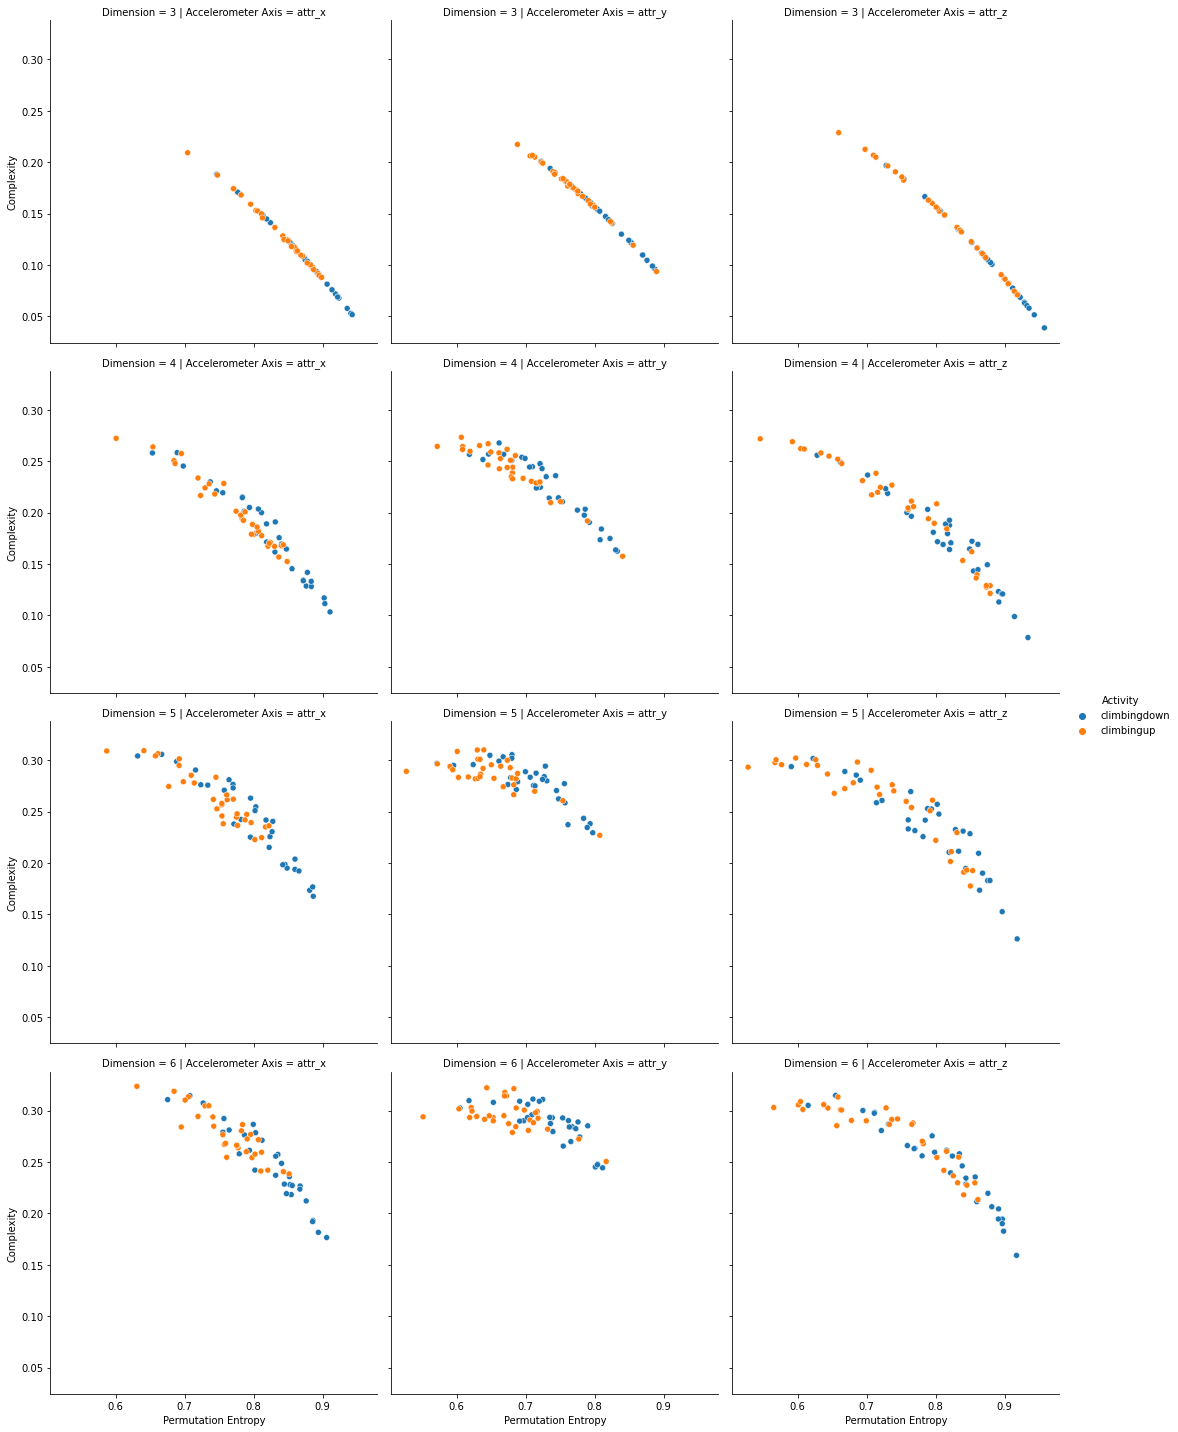

In [ ]:
#displaying the scatterplot for Permutation Entropy vs Complexity of climbing up and climbing down
sns.relplot(data=cliup_clidown_1,x='Permutation Entropy',y='Complexity',hue='Activity',col='Accelerometer Axis',row='Dimension')
plt.show()

In [87]:
!jupyter nbconvert --to html Project_2_task_2_Group38.ipynb

/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `jupyter nbconvert --to html Project_2_task_2_Group38 (2).ipynb'
